In [2]:
pip install gdown

Note: you may need to restart the kernel to use updated packages.


In [13]:
import pandas as pd
import gdown
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score

# تنظیم عدد تکرارپذیری بر اساس شماره دانشجویی شما
my_random_state = 53 

# دانلود و بارگذاری دیتاست
file_id = '1I577Z13ACYpK9U2zT4lQBA1aMANlDbfV'
url = f'https://drive.google.com/uc?id={file_id}'
output = 'Mall_Customers.csv'
gdown.download(url, output, quiet=False)

df = pd.read_csv(output)

# انتخاب ویژگی‌های عددی و استانداردسازی
numeric_cols = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
x = df[numeric_cols]
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

# ساخت PCA دو بعدی برای نمایش (با رعایت اصل تکرارپذیری)
pca = PCA(n_components=2, random_state=my_random_state)
x_pca = pca.fit_transform(x_scaled)
df_pca = pd.DataFrame(data=x_pca, columns=['PC1', 'PC2'])

print("بخش اول با موفقیت انجام شد.")

Downloading...
From: https://drive.google.com/uc?id=1I577Z13ACYpK9U2zT4lQBA1aMANlDbfV
To: c:\Users\Razan kala\Desktop\Mall_Customers.csv
100%|██████████| 3.98k/3.98k [00:00<00:00, 1.33MB/s]

بخش اول با موفقیت انجام شد.


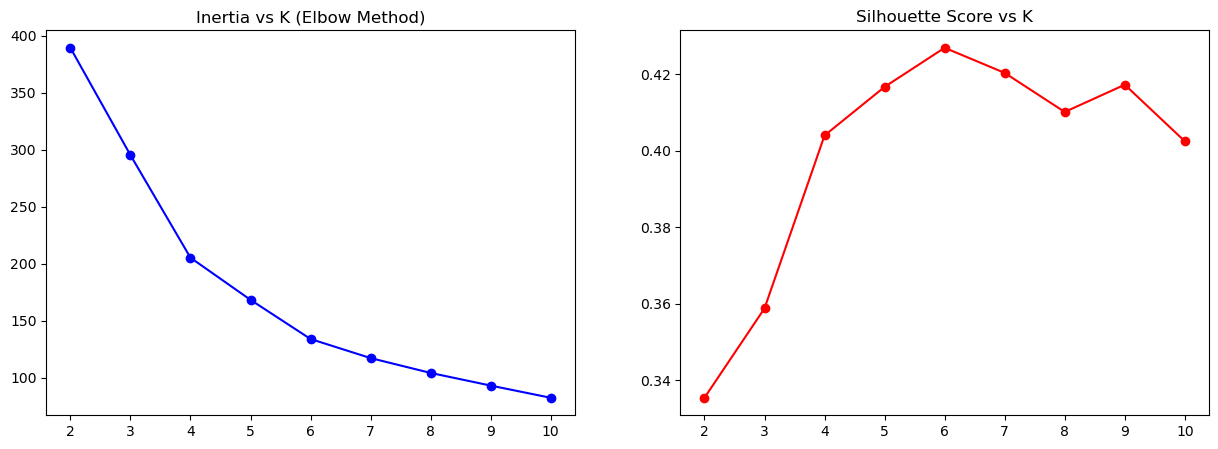

In [14]:
wcss = []
silhouette_list = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=my_random_state)
    labels = kmeans.fit_predict(x_scaled)
    wcss.append(kmeans.inertia_)
    silhouette_list.append(silhouette_score(x_scaled, labels))

# رسم نمودارهای آرنج و سیلوئت
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(k_range, wcss, marker='o', color='b')
ax1.set_title('Inertia vs K (Elbow Method)')
ax2.plot(k_range, silhouette_list, marker='o', color='r')
ax2.set_title('Silhouette Score vs K')
plt.show()

# استدلال: بر اساس نمودارها، K=6 به عنوان مقدار بهینه انتخاب می‌شود.

Linkage: single     | Silhouette Score: -0.0428
Linkage: complete   | Silhouette Score: 0.3746
Linkage: average    | Silhouette Score: 0.3896
Linkage: ward       | Silhouette Score: 0.4201


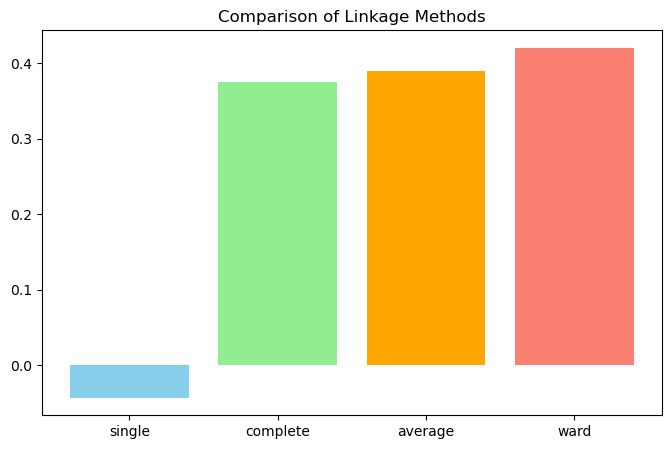

In [15]:
linkages = ['single', 'complete', 'average', 'ward']
results_agg = {}

for link in linkages:
    model = AgglomerativeClustering(n_clusters=6, linkage=link)
    labels = model.fit_predict(x_scaled)
    score = silhouette_score(x_scaled, labels)
    results_agg[link] = score
    print(f"Linkage: {link:10} | Silhouette Score: {score:.4f}")

# رسم نمودار مقایسه‌ای
plt.figure(figsize=(8, 5))
plt.bar(results_agg.keys(), results_agg.values(), color=['skyblue', 'lightgreen', 'orange', 'salmon'])
plt.title('Comparison of Linkage Methods')
plt.show()

In [16]:
eps_values = [0.2, 0.4, 0.6, 0.8, 1.0]
min_samples_values = [3, 5, 10]

print(f"{'Eps':<5} | {'MinSam':<6} | {'Clusters':<8} | {'Noise %':<8} | {'Silhouette':<10}")
print("-" * 50)

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(x_scaled)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        noise_ratio = (n_noise / len(labels)) * 100
        
        if n_clusters > 1:
            mask = labels != -1
            score = silhouette_score(x_scaled[mask], labels[mask])
        else:
            score = float('nan')
        print(f"{eps:<5} | {min_samples:<6} | {n_clusters:<8} | {noise_ratio:<8.1f}% | {score:.4f}")

Eps   | MinSam | Clusters | Noise %  | Silhouette
--------------------------------------------------
0.2   | 3      | 11       | 80.5    % | 0.6459
0.2   | 5      | 1        | 97.5    % | nan
0.2   | 10     | 0        | 100.0   % | nan
0.4   | 3      | 10       | 29.5    % | 0.4426
0.4   | 5      | 6        | 49.0    % | 0.5190
0.4   | 10     | 2        | 85.0    % | 0.7661
0.6   | 3      | 3        | 7.0     % | 0.2149
0.6   | 5      | 2        | 14.0    % | 0.2730
0.6   | 10     | 4        | 33.0    % | 0.5296
0.8   | 3      | 1        | 1.5     % | nan
0.8   | 5      | 1        | 3.0     % | nan
0.8   | 10     | 1        | 11.5    % | nan
1.0   | 3      | 1        | 0.5     % | nan
1.0   | 5      | 1        | 1.0     % | nan
1.0   | 10     | 1        | 2.5     % | nan


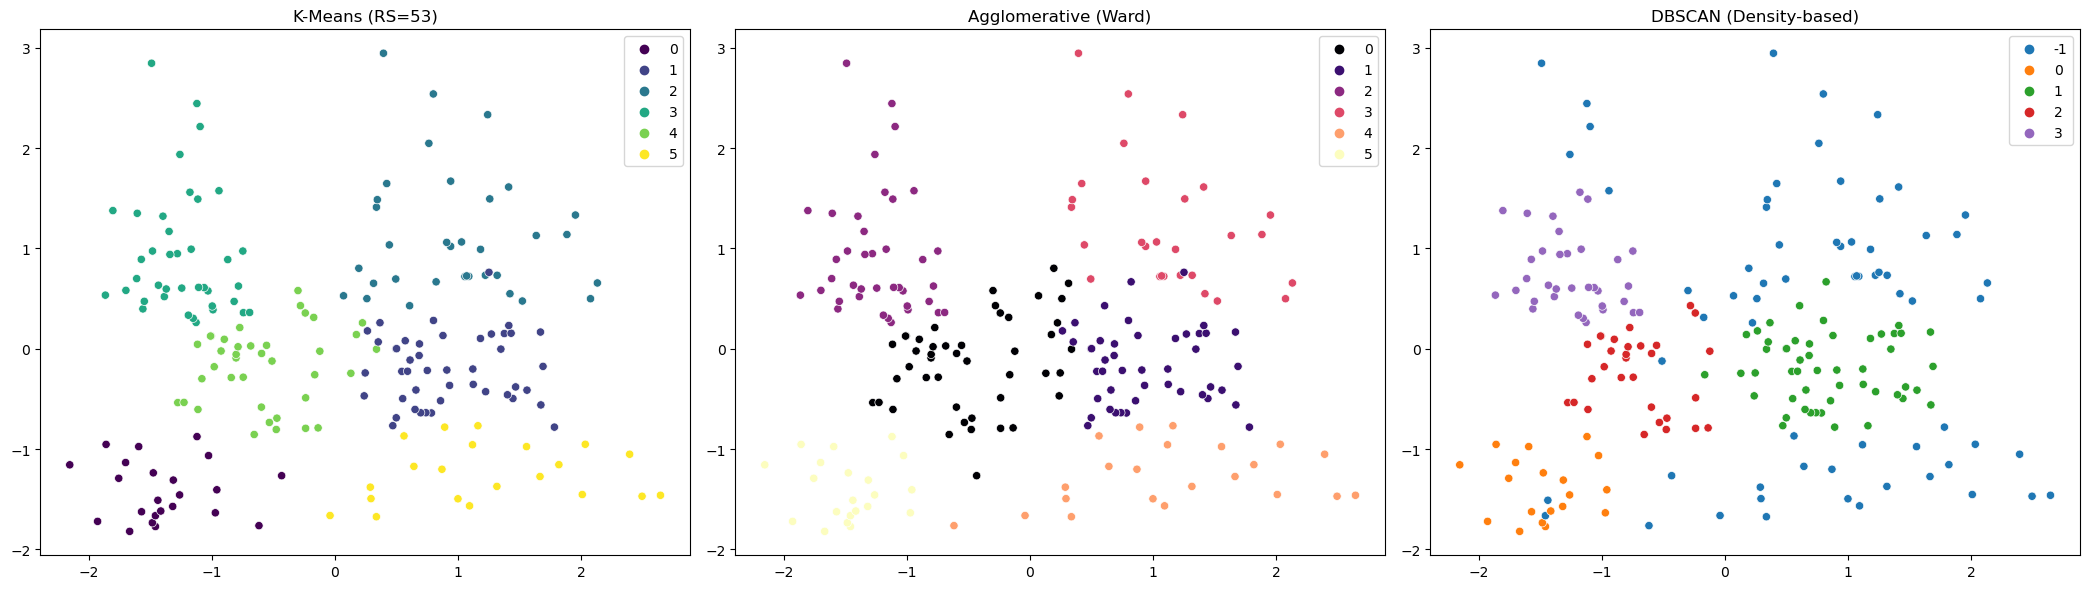

In [17]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21, 6))

# 1. K-Means
km = KMeans(n_clusters=6, init='k-means++', random_state=my_random_state)
sns.scatterplot(x=x_pca[:,0], y=x_pca[:,1], hue=km.fit_predict(x_scaled), palette='viridis', ax=ax1)
ax1.set_title(f'K-Means (RS={my_random_state})')

# 2. Agglomerative (Ward)
agg = AgglomerativeClustering(n_clusters=6, linkage='ward')
sns.scatterplot(x=x_pca[:,0], y=x_pca[:,1], hue=agg.fit_predict(x_scaled), palette='magma', ax=ax2)
ax2.set_title('Agglomerative (Ward)')

# 3. DBSCAN (Eps=0.6, MinSam=10)
db = DBSCAN(eps=0.6, min_samples=10)
sns.scatterplot(x=x_pca[:,0], y=x_pca[:,1], hue=db.fit_predict(x_scaled), palette='tab10', ax=ax3)
ax3.set_title('DBSCAN (Density-based)')

plt.tight_layout()
plt.show()